In [1]:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
# https://www.kaggle.com/borisdee/predicting-mulliken-charges-with-acsf-descriptors
# oof_fc, oof_sd, oof_pso, oof_dso by type with bond lengths, that is nb6 plus bond lengths + mulliken charges

In [2]:
import numpy as np
import pandas as pd
import os

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

alt.renderers.enable('notebook')

from artgor_utils import *

In [3]:
file_folder = '../data'
train = pd.read_csv(f'{file_folder}/train.csv')
test = pd.read_csv(f'{file_folder}/test.csv')
sub = pd.read_csv(f'{file_folder}/sample_submission.csv')
structures = pd.read_csv(f'{file_folder}/structures.csv')
scalar_coupling_contributions = pd.read_csv(f'{file_folder}/scalar_coupling_contributions.csv')
mc = pd.read_csv(f'{file_folder}/mulliken_charges.csv')
tmc = pd.read_csv(f'{file_folder}/mulliken_charges_test_set.csv')

In [4]:
structures.shape

(2358657, 6)

In [5]:
mc.head()

molecule_name  atom_index  mulliken_charge
0  dsgdb9nsd_000001           0        -0.535689
1  dsgdb9nsd_000001           1         0.133921
2  dsgdb9nsd_000001           2         0.133922
3  dsgdb9nsd_000001           3         0.133923
4  dsgdb9nsd_000001           4         0.133923

In [6]:
tmc.head()

molecule_name  atom_index    mulliken_charge
0  dsgdb9nsd_000004           0 -0.382772375036169
1  dsgdb9nsd_000004           1 -0.382772375036169
2  dsgdb9nsd_000004           2  0.175372532425211
3  dsgdb9nsd_000004           3  0.175372532425211
4  dsgdb9nsd_000015           0 -0.227002161442758

In [7]:
structures.head()

molecule_name  atom_index atom             x             y             z
0  dsgdb9nsd_000001           0    C -0.0126981359  1.0858041580  0.0080009958
1  dsgdb9nsd_000001           1    H  0.0021504160 -0.0060313176  0.0019761204
2  dsgdb9nsd_000001           2    H  1.0117308430  1.4637511620  0.0002765748
3  dsgdb9nsd_000001           3    H -0.5408150690  1.4475266140 -0.8766437152
4  dsgdb9nsd_000001           4    H -0.5238136345  1.4379326440  0.9063972942

In [8]:
mc.shape, tmc.shape

((1533537, 3), (825120, 3))

In [9]:
mc_tmc = mc.append(tmc)

In [10]:
mc_tmc.shape

(2358657, 3)

In [11]:
mc_tmc.head()

molecule_name  atom_index  mulliken_charge
0  dsgdb9nsd_000001           0        -0.535689
1  dsgdb9nsd_000001           1         0.133921
2  dsgdb9nsd_000001           2         0.133922
3  dsgdb9nsd_000001           3         0.133923
4  dsgdb9nsd_000001           4         0.133923

In [12]:
mc_tmc.isnull().sum()

molecule_name      0
atom_index         0
mulliken_charge    0
dtype: int64

In [13]:
structures = pd.merge(mc_tmc, structures, how = 'left',
                  left_on  = ['molecule_name', 'atom_index'],
                  right_on = ['molecule_name',  'atom_index'])

In [14]:
structures.shape

(2358657, 7)

In [15]:
from tqdm import tqdm_notebook as tqdm
atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor

fudge_factor = 0.05
atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}
print(atomic_radius)

electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

#structures = pd.read_csv(structures, dtype={'atom_index':np.int8})

atoms = structures['atom'].values
atoms_en = [electronegativity[x] for x in tqdm(atoms)]
atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]

structures['EN'] = atoms_en
structures['rad'] = atoms_rad

display(structures.head())

{'H': 0.43, 'C': 0.8200000000000001, 'N': 0.8, 'O': 0.78, 'F': 0.76}


HBox(children=(IntProgress(value=0, max=2358657), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2358657), HTML(value='')))

molecule_name  atom_index  mulliken_charge atom             x  \
0  dsgdb9nsd_000001           0        -0.535689    C -0.0126981359   
1  dsgdb9nsd_000001           1         0.133921    H  0.0021504160   
2  dsgdb9nsd_000001           2         0.133922    H  1.0117308430   
3  dsgdb9nsd_000001           3         0.133923    H -0.5408150690   
4  dsgdb9nsd_000001           4         0.133923    H -0.5238136345   

              y             z    EN   rad  
0  1.0858041580  0.0080009958  2.55  0.82  
1 -0.0060313176  0.0019761204  2.20  0.43  
2  1.4637511620  0.0002765748  2.20  0.43  
3  1.4475266140 -0.8766437152  2.20  0.43  
4  1.4379326440  0.9063972942  2.20  0.43

In [16]:
i_atom = structures['atom_index'].values
p = structures[['x', 'y', 'z']].values
p_compare = p
m = structures['molecule_name'].values
m_compare = m
r = structures['rad'].values
r_compare = r

source_row = np.arange(len(structures))
max_atoms = 28

bonds = np.zeros((len(structures)+1, max_atoms+1), dtype=np.int8)
bond_dists = np.zeros((len(structures)+1, max_atoms+1), dtype=np.float32)

print('Calculating the bonds')

for i in tqdm(range(max_atoms-1)):
    p_compare = np.roll(p_compare, -1, axis=0)
    m_compare = np.roll(m_compare, -1, axis=0)
    r_compare = np.roll(r_compare, -1, axis=0)
    
    mask = np.where(m == m_compare, 1, 0) #Are we still comparing atoms in the same molecule?
    dists = np.linalg.norm(p - p_compare, axis=1) * mask
    r_bond = r + r_compare
    
    bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)
    
    source_row = source_row
    target_row = source_row + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_row = np.where(np.logical_or(target_row > len(structures), mask==0), len(structures), target_row) #If invalid target, write
    
    source_atom = i_atom
    target_atom = i_atom + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom) #If invalid target, write to dummy col
    
    bonds[(source_row, target_atom)] = bond
    bonds[(target_row, source_atom)] = bond
    bond_dists[(source_row, target_atom)] = dists
    bond_dists[(target_row, source_atom)] = dists

bonds = np.delete(bonds, axis=0, obj=-1) #Delete dummy row
bonds = np.delete(bonds, axis=1, obj=-1) #Delete dummy col
bond_dists = np.delete(bond_dists, axis=0, obj=-1) #Delete dummy row
bond_dists = np.delete(bond_dists, axis=1, obj=-1) #Delete dummy col

print('Counting and condensing bonds')

bonds_numeric = [[i for i,x in enumerate(row) if x] for row in tqdm(bonds)]
bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(tqdm(bond_dists))]
bond_lengths_mean = [ np.mean(x) for x in bond_lengths]
n_bonds = [len(x) for x in bonds_numeric]

#bond_data = {'bond_' + str(i):col for i, col in enumerate(np.transpose(bonds))}
#bond_data.update({'bonds_numeric':bonds_numeric, 'n_bonds':n_bonds})

bond_data = {'n_bonds':n_bonds, 'bond_lengths_mean': bond_lengths_mean }
bond_df = pd.DataFrame(bond_data)
structures = structures.join(bond_df)
display(structures.head(20))

Calculating the bonds


HBox(children=(IntProgress(value=0, max=27), HTML(value='')))


Counting and condensing bonds


HBox(children=(IntProgress(value=0, max=2358657), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2358657), HTML(value='')))

molecule_name  atom_index  mulliken_charge atom             x  \
0   dsgdb9nsd_000001           0        -0.535689    C -0.0126981359   
1   dsgdb9nsd_000001           1         0.133921    H  0.0021504160   
2   dsgdb9nsd_000001           2         0.133922    H  1.0117308430   
3   dsgdb9nsd_000001           3         0.133923    H -0.5408150690   
4   dsgdb9nsd_000001           4         0.133923    H -0.5238136345   
5   dsgdb9nsd_000002           0        -0.707143    N -0.0404260543   
6   dsgdb9nsd_000002           1         0.235712    H  0.0172574639   
7   dsgdb9nsd_000002           2         0.235712    H  0.9157893661   
8   dsgdb9nsd_000002           3         0.235720    H -0.5202777357   
9   dsgdb9nsd_000003           0        -0.589706    O -0.0343604951   
10  dsgdb9nsd_000003           1         0.294853    H  0.0647664923   
11  dsgdb9nsd_000003           2         0.294853    H  0.8717903737   
12  dsgdb9nsd_000005           0        -0.049655    C -0.0133239314   
13  dsgdb9nsd_000005           1        -0.188473    N  0.0023107217   
14  dsgdb9nsd_000005           2         0.238128    H -0.0278026991   
15  dsgdb9nsd_000007           0        -0.345672    C -0.0187040036   
16  dsgdb9nsd_000007           1        -0.345672    C  0.0021037439   
17  dsgdb9nsd_000007           2         0.115222    H  0.9948727479   
18  dsgdb9nsd_000007           3         0.115225    H -0.5420761069   
19  dsgdb9nsd_000007           4         0.115225    H -0.5252411248   

               y             z    EN   rad  bond_lengths_mean  n_bonds  
0   1.0858041580  0.0080009958  2.55  0.82  1.091949701309204        4  
1  -0.0060313176  0.0019761204  2.20  0.43  1.091953039169312        1  
2   1.4637511620  0.0002765748  2.20  0.43  1.091951608657837        1  
3   1.4475266140 -0.8766437152  2.20  0.43  1.091946363449097        1  
4   1.4379326440  0.9063972942  2.20  0.43  1.091947555541992        1  
5   1.0241077530  0.0625637998  3.04  0.80  1.017194986343384        3  
6   0.0125452063 -0.0273771593  2.20  0.43  1.017189979553223        1  
7   1.3587451950 -0.0287577581  2.20  0.43  1.017187237739563        1  
8   1.3435321260 -0.7755426124  2.20  0.43  1.017207860946655        1  
9   0.9775395708  0.0076015923  3.44  0.78  0.962106823921204        2  
10  0.0205721989  0.0015346341  2.20  0.43  0.962106823921204        1  
11  1.3007924050  0.0006931336  2.20  0.43  0.962106823921204        1  
12  1.1324657150  0.0082758861  2.55  0.82  1.109173059463501        2  
13 -0.0191585871  0.0019287305  3.04  0.80  1.151747941970825        1  
14  2.1989492960  0.0141537903  2.20  0.43  1.066598057746887        1  
15  1.5255820150  0.0104328082  2.55  0.82  1.203627109527588        4  
16 -0.0038819102  0.0019988214  2.55  0.82  1.203627109527588        4  
17  1.9397432360  0.0029412016  2.20  0.43  1.094953656196594        1  
18  1.9236106320 -0.8651173523  2.20  0.43  1.094958066940308        1  
19  1.9141730780  0.9000239916  2.20  0.43  1.094968199729919        1

In [17]:
train = pd.merge(train, scalar_coupling_contributions, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [18]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

In [19]:
train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [20]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

In [21]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])

train['type_1'] = train['type'].apply(lambda x: x[1:])
test['type_1'] = test['type'].apply(lambda x: x[1:])

In [22]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 488.66 Mb (60.7% reduction)
Mem. usage decreased to 238.95 Mb (58.3% reduction)


In [23]:
def create_features_full(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_median'] = df.groupby('molecule_name')['dist'].transform('median')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['molecule_dist_std'] = df.groupby('molecule_name')['dist'].transform('std')
    
    
    
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df['type_0_couples_count'] = df.groupby(['molecule_name', 'type_0'])['id'].transform('count')
    df['type_1_couples_count'] = df.groupby(['molecule_name', 'type_1'])['id'].transform('count')
    
#     df['molecule_distx_mean'] = df.groupby('molecule_name')['dist_x'].transform('mean')
#     df['molecule_distx_median'] = df.groupby('molecule_name')['dist_x'].transform('median')
#     df['molecule_distx_min'] = df.groupby('molecule_name')['dist_x'].transform('min')
#     df['molecule_distx_max'] = df.groupby('molecule_name')['dist_x'].transform('max')
#     df['molecule_distx_std'] = df.groupby('molecule_name')['dist_x'].transform('std')
    
    
    
#     df['molecule_disty_mean'] = df.groupby('molecule_name')['dist_y'].transform('mean')
#     df['molecule_disty_median'] = df.groupby('molecule_name')['dist_y'].transform('median')
#     df['molecule_disty_min'] = df.groupby('molecule_name')['dist_y'].transform('min')
#     df['molecule_disty_max'] = df.groupby('molecule_name')['dist_y'].transform('max')
#     df['molecule_disty_std'] = df.groupby('molecule_name')['dist_y'].transform('std')
   
   
    
    
#     df['molecule_distz_mean'] = df.groupby('molecule_name')['dist_z'].transform('mean')
#     df['molecule_distz_median'] = df.groupby('molecule_name')['dist_z'].transform('median')
#     df['molecule_distz_min'] = df.groupby('molecule_name')['dist_z'].transform('min')
#     df['molecule_distz_max'] = df.groupby('molecule_name')['dist_z'].transform('max')
#     df['molecule_distz_std'] = df.groupby('molecule_name')['dist_z'].transform('std')
    
   
    
    
    num_cols = ['x_1', 'y_1', 'z_1', 'dist', 'dist_x', 'dist_y', 'dist_z']
    cat_cols = ['atom_index_0', 'atom_index_1', 'type', 'atom_1', 'type_0']
    
#     aggs = ['mean', 'max', 'std', 'min']
    aggs = ['mean', 'max', 'std', 'min']
    for col in cat_cols:
        df[f'molecule_{col}_count'] = df.groupby('molecule_name')[col].transform('count')

    for cat_col in tqdm_notebook(cat_cols):
        for num_col in num_cols:
            for agg in aggs:
                df[f'molecule_{cat_col}_{num_col}_{agg}'] = df.groupby(['molecule_name', cat_col])[num_col].transform(agg)
                df[f'molecule_{cat_col}_{num_col}_{agg}_diff'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] - df[num_col]
                df[f'molecule_{cat_col}_{num_col}_{agg}_div'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] / df[num_col]
#                 df[f'molecule_{cat_col}_{num_col}_{agg}_sum'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] + df[num_col]
#                 df[f'molecule_{cat_col}_{num_col}_{agg}_mult'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] * df[num_col]


    df = reduce_mem_usage(df)
    return df

In [24]:
train = create_features_full(train)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Mem. usage decreased to 6814.57 Mb (-50.4% reduction)


In [25]:
test = create_features_full(test)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Mem. usage decreased to 3641.55 Mb (-50.9% reduction)


In [26]:
# train.to_csv('../cache/train2.csv', index=False)
# test.to_csv('../cache/test2.csv', index=False)

In [27]:
# train = pd.read_csv('../cache/train2.csv')
# test = pd.read_csv('../cache/test2.csv')

In [28]:
for f in ['atom_index_0', 'atom_index_1', 'atom_1', 'type_0', 'type', 'atom_0', 'type_1']:
#     if f in good_columns:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(test[f].values))
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

In [29]:
# train = reduce_mem_usage(train)
# test = reduce_mem_usage(test)

In [38]:
good_columns = [
'molecule_atom_index_0_dist_min',
'molecule_atom_index_0_dist_max',
'molecule_atom_index_1_dist_min',
'molecule_atom_index_0_dist_mean',
'molecule_atom_index_0_dist_std',
'dist',
'molecule_atom_index_1_dist_std',
'molecule_atom_index_1_dist_max',
'molecule_atom_index_1_dist_mean',
'molecule_atom_index_0_dist_max_diff',
'molecule_atom_index_0_dist_max_div',
'molecule_atom_index_0_dist_std_diff',
'molecule_atom_index_0_dist_std_div',
'atom_0_couples_count',
'molecule_atom_index_0_dist_min_div',
'molecule_atom_index_1_dist_std_diff',
'molecule_atom_index_0_dist_mean_div',
'atom_1_couples_count',
'molecule_atom_index_0_dist_mean_diff',
'molecule_couples',
'atom_index_1',
'molecule_dist_mean',
'molecule_atom_index_1_dist_max_diff',
'molecule_atom_index_0_y_1_std',
'molecule_atom_index_1_dist_mean_diff',
'molecule_atom_index_1_dist_std_div',
'molecule_atom_index_1_dist_mean_div',
'molecule_atom_index_1_dist_min_diff',
'molecule_atom_index_1_dist_min_div',
'molecule_atom_index_1_dist_max_div',
'molecule_atom_index_0_z_1_std',
'y_0',
'molecule_type_dist_std_diff',
'molecule_atom_1_dist_min_diff',
'molecule_atom_index_0_x_1_std',
'molecule_dist_min',
'molecule_atom_index_0_dist_min_diff',
'molecule_atom_index_0_y_1_mean_diff',
'molecule_type_dist_min',
'molecule_atom_1_dist_min_div',
'atom_index_0',
'molecule_dist_max',
'molecule_atom_1_dist_std_diff',
'molecule_type_dist_max',
'molecule_atom_index_0_y_1_max_diff',
'molecule_type_0_dist_std_diff',
'molecule_type_dist_mean_diff',
'molecule_atom_1_dist_mean',
'molecule_atom_index_0_y_1_mean_div',
'molecule_type_dist_mean_div',
'type',
'EN_x', 'rad_x',
'n_bonds_x', 'bond_lengths_mean_x','EN_y', 'rad_y', 'n_bonds_y', 'bond_lengths_mean_y',
'mulliken_charge_x', 'mulliken_charge_y'
]

In [39]:
# for f in ['atom_0', 'type_1']:
# #     if f in good_columns:
#     lbl = LabelEncoder()
#     lbl.fit(list(X[f].values) + list(X_test[f].values))
#     X[f] = lbl.transform(list(X[f].values))
#     X_test[f] = lbl.transform(list(X_test[f].values))

In [40]:
# X = train[good_columns].copy()
# y = train['scalar_coupling_constant']
# X_test = test[good_columns].copy()

In [41]:
# X = train.copy()
# y = train['scalar_coupling_constant']
# del train

# X_test = test.copy()
# del test
# del structures

In [42]:
# X = X.drop(['id', 'molecule_name', 'scalar_coupling_constant'], axis=1)

# X_test = X_test.drop(['id', 'molecule_name'], axis=1)

In [44]:
X = train[good_columns].copy()
y1 = train['scalar_coupling_constant']
y_fc = train['fc']
y_sd = train['sd']
y_pso = train['pso']
y_dso = train['dso']
X_test = test[good_columns].copy()

In [45]:
del train, test

In [46]:
import gc
gc.collect()

243

In [47]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [48]:
# params = {'num_leaves': 128,
#           'min_child_samples': 79,
#           'objective': 'regression',
#           'max_depth': 9,
#           'learning_rate': 0.2,
#           "boosting_type": "gbdt",
#           "subsample_freq": 1,
#           "subsample": 0.9,
#           "bagging_seed": 11,
#           "metric": 'mae',
#           "verbosity": -1,
#           'reg_alpha': 0.1,
#           'reg_lambda': 0.3,
#           'colsample_bytree': 1.0
#          }
# result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
#                                                       verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [49]:
y = y_fc
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

In [50]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
    
# sub['scalar_coupling_constant'] = X_short_test['prediction']
# sub.to_csv('../submissions/sub5.csv', index=False)
# sub.head()

Training of type 0
Fold 1 started at Fri Jun 21 17:43:59 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.12975	valid_1's l1: 1.36929
[1000]	training's l1: 0.898898	valid_1's l1: 1.27018
[1500]	training's l1: 0.750748	valid_1's l1: 1.22229
[2000]	training's l1: 0.641676	valid_1's l1: 1.19517
[2500]	training's l1: 0.557258	valid_1's l1: 1.17733
[3000]	training's l1: 0.488258	valid_1's l1: 1.16422
[3500]	training's l1: 0.430365	valid_1's l1: 1.15498
[4000]	training's l1: 0.382176	valid_1's l1: 1.14813
[4500]	training's l1: 0.340872	valid_1's l1: 1.14255
[5000]	training's l1: 0.305331	valid_1's l1: 1.13841
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.305331	valid_1's l1: 1.13841
Fold 2 started at Fri Jun 21 17:48:22 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.12918	valid_1's l1: 1.37057
[1000]	training's l1: 0.895872	valid_1's l1: 1.26891
[1500]	training's l1: 0.748568	valid

[500]	training's l1: 0.234575	valid_1's l1: 0.507126
[1000]	training's l1: 0.120559	valid_1's l1: 0.489972
[1500]	training's l1: 0.0641151	valid_1's l1: 0.485578
[2000]	training's l1: 0.0344913	valid_1's l1: 0.483842
[2500]	training's l1: 0.0185006	valid_1's l1: 0.483243
[3000]	training's l1: 0.00973253	valid_1's l1: 0.483002
Early stopping, best iteration is:
[2855]	training's l1: 0.0116876	valid_1's l1: 0.482964
Fold 3 started at Fri Jun 21 18:17:07 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.231783	valid_1's l1: 0.502535
[1000]	training's l1: 0.117455	valid_1's l1: 0.487771
[1500]	training's l1: 0.0633449	valid_1's l1: 0.483885
[2000]	training's l1: 0.0343676	valid_1's l1: 0.482438
[2500]	training's l1: 0.018466	valid_1's l1: 0.481799
[3000]	training's l1: 0.00987054	valid_1's l1: 0.481526
[3500]	training's l1: 0.00557769	valid_1's l1: 0.481354
[4000]	training's l1: 0.00365443	valid_1's l1: 0.481287
[4500]	training's l1: 0.00275703	vali

[2000]	training's l1: 0.407521	valid_1's l1: 0.638586
[2500]	training's l1: 0.363831	valid_1's l1: 0.626151
[3000]	training's l1: 0.327649	valid_1's l1: 0.616985
[3500]	training's l1: 0.297112	valid_1's l1: 0.610573
[4000]	training's l1: 0.27045	valid_1's l1: 0.604712
[4500]	training's l1: 0.247415	valid_1's l1: 0.600294
[5000]	training's l1: 0.22709	valid_1's l1: 0.596897
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.22709	valid_1's l1: 0.596897
Fold 4 started at Fri Jun 21 18:41:39 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.652956	valid_1's l1: 0.739487
[1000]	training's l1: 0.534904	valid_1's l1: 0.678776
[1500]	training's l1: 0.462046	valid_1's l1: 0.650481
[2000]	training's l1: 0.407703	valid_1's l1: 0.632851
[2500]	training's l1: 0.363826	valid_1's l1: 0.620265
[3000]	training's l1: 0.32804	valid_1's l1: 0.611258
[3500]	training's l1: 0.297265	valid_1's l1: 0.604228
[4000]	training's l1: 0.270985	valid_1's 

[1000]	training's l1: 0.630174	valid_1's l1: 0.759223
[1500]	training's l1: 0.554743	valid_1's l1: 0.723827
[2000]	training's l1: 0.498277	valid_1's l1: 0.701189
[2500]	training's l1: 0.45287	valid_1's l1: 0.685396
[3000]	training's l1: 0.41463	valid_1's l1: 0.673562
[3500]	training's l1: 0.382082	valid_1's l1: 0.664545
[4000]	training's l1: 0.353476	valid_1's l1: 0.657317
[4500]	training's l1: 0.328553	valid_1's l1: 0.651648
[5000]	training's l1: 0.305926	valid_1's l1: 0.646523
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.305926	valid_1's l1: 0.646523
Fold 5 started at Fri Jun 21 19:38:07 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.753187	valid_1's l1: 0.830846
[1000]	training's l1: 0.632408	valid_1's l1: 0.758372
[1500]	training's l1: 0.556352	valid_1's l1: 0.722374
[2000]	training's l1: 0.499023	valid_1's l1: 0.699009
[2500]	training's l1: 0.453213	valid_1's l1: 0.683355
[3000]	training's l1: 0.414803	valid_1'

In [51]:
oof_fc = X_short['oof'].values
test_oof_fc = X_short_test['prediction'].values

Fold 1 started at Fri Jun 21 19:52:18 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.950631	valid_1's l1: 0.987818
[1000]	training's l1: 0.831363	valid_1's l1: 0.893709
[1500]	training's l1: 0.759319	valid_1's l1: 0.842537
[2000]	training's l1: 0.706681	valid_1's l1: 0.808102
[2500]	training's l1: 0.66675	valid_1's l1: 0.785406
[3000]	training's l1: 0.633003	valid_1's l1: 0.766886
[3500]	training's l1: 0.603767	valid_1's l1: 0.751654
[4000]	training's l1: 0.578632	valid_1's l1: 0.739819
[4500]	training's l1: 0.555462	valid_1's l1: 0.729062
[5000]	training's l1: 0.534595	valid_1's l1: 0.720079
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.534595	valid_1's l1: 0.720079
Fold 2 started at Fri Jun 21 20:11:44 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.946227	valid_1's l1: 0.983145
[1000]	training's l1: 0.828042	valid_1's l1: 0.890215
[1500]	training's l1: 0.758039	valid_1's 

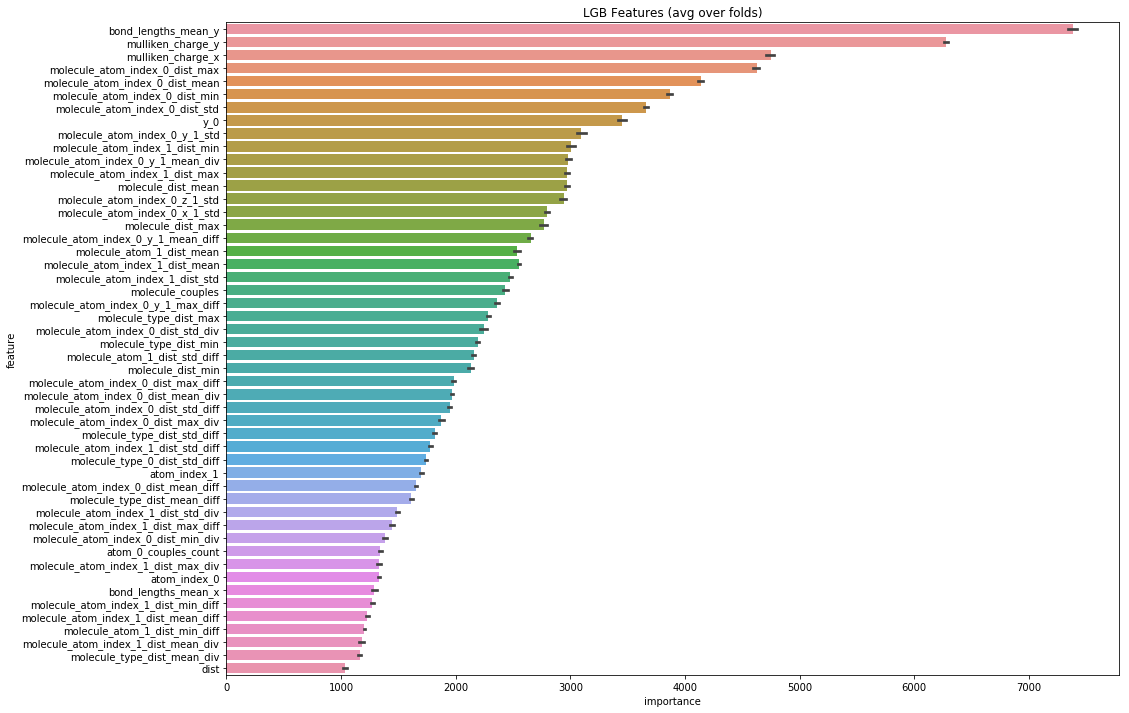

In [52]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb1 = train_model_regression(X=X, X_test=X_test, y=y_fc, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [53]:
oof_fc = result_dict_lgb1['oof']
test_oof_fc = result_dict_lgb1['prediction']

In [54]:
y = y_sd
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

In [55]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
    

Training of type 0
Fold 1 started at Fri Jun 21 21:30:50 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00760436	valid_1's l1: 0.00920842
[1000]	training's l1: 0.00598057	valid_1's l1: 0.00839714
[1500]	training's l1: 0.00502408	valid_1's l1: 0.00804112
[2000]	training's l1: 0.00432605	valid_1's l1: 0.00782296
[2500]	training's l1: 0.00380363	valid_1's l1: 0.00767733
[3000]	training's l1: 0.00338963	valid_1's l1: 0.00757234
[3500]	training's l1: 0.00305546	valid_1's l1: 0.00750279
[4000]	training's l1: 0.00278007	valid_1's l1: 0.00744688
[4500]	training's l1: 0.00254785	valid_1's l1: 0.00740466
[5000]	training's l1: 0.00235018	valid_1's l1: 0.00737043
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00235018	valid_1's l1: 0.00737043
Fold 2 started at Fri Jun 21 21:35:17 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00755896	valid_1's l1: 0.00917634
[1000]	training's l1: 0.005

[1500]	training's l1: 0.00144126	valid_1's l1: 0.00540817
[2000]	training's l1: 0.00132601	valid_1's l1: 0.00539705
[2500]	training's l1: 0.0012499	valid_1's l1: 0.00538984
[3000]	training's l1: 0.00119447	valid_1's l1: 0.00538628
[3500]	training's l1: 0.00115163	valid_1's l1: 0.00538413
[4000]	training's l1: 0.00111589	valid_1's l1: 0.00538213
Early stopping, best iteration is:
[4218]	training's l1: 0.00110182	valid_1's l1: 0.00538115
Fold 2 started at Fri Jun 21 22:09:26 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00224669	valid_1's l1: 0.00554103
[1000]	training's l1: 0.00164834	valid_1's l1: 0.005464
[1500]	training's l1: 0.00143516	valid_1's l1: 0.00544147
[2000]	training's l1: 0.00131741	valid_1's l1: 0.00543349
[2500]	training's l1: 0.00124212	valid_1's l1: 0.00542626
[3000]	training's l1: 0.00118604	valid_1's l1: 0.00542217
[3500]	training's l1: 0.00114405	valid_1's l1: 0.00542037
Early stopping, best iteration is:
[3682]	training'

[2500]	training's l1: 0.00600421	valid_1's l1: 0.0100173
[3000]	training's l1: 0.00543778	valid_1's l1: 0.00985045
[3500]	training's l1: 0.00497007	valid_1's l1: 0.00973645
[4000]	training's l1: 0.00456092	valid_1's l1: 0.0096314
[4500]	training's l1: 0.00421012	valid_1's l1: 0.00955151
[5000]	training's l1: 0.00390597	valid_1's l1: 0.00948763
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00390597	valid_1's l1: 0.00948763
Fold 3 started at Fri Jun 21 22:29:09 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0105959	valid_1's l1: 0.012187
[1000]	training's l1: 0.00877351	valid_1's l1: 0.0111999
[1500]	training's l1: 0.0075916	valid_1's l1: 0.010679
[2000]	training's l1: 0.00671106	valid_1's l1: 0.0103547
[2500]	training's l1: 0.00600521	valid_1's l1: 0.010115
[3000]	training's l1: 0.00544284	valid_1's l1: 0.00995366
[3500]	training's l1: 0.00497069	valid_1's l1: 0.00982268
[4000]	training's l1: 0.00456748	valid_1's l1: 

[4500]	training's l1: 0.00371004	valid_1's l1: 0.00705409
[5000]	training's l1: 0.00349073	valid_1's l1: 0.00700054
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00349073	valid_1's l1: 0.00700054
Fold 3 started at Fri Jun 21 23:22:16 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00805299	valid_1's l1: 0.00894476
[1000]	training's l1: 0.00680476	valid_1's l1: 0.00821681
[1500]	training's l1: 0.00602946	valid_1's l1: 0.00785558
[2000]	training's l1: 0.00544583	valid_1's l1: 0.00761979
[2500]	training's l1: 0.00498189	valid_1's l1: 0.00744833
[3000]	training's l1: 0.00459125	valid_1's l1: 0.00731584
[3500]	training's l1: 0.00426048	valid_1's l1: 0.00720999
[4000]	training's l1: 0.00397665	valid_1's l1: 0.00713125
[4500]	training's l1: 0.00372545	valid_1's l1: 0.00706475
[5000]	training's l1: 0.00350156	valid_1's l1: 0.00700478
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00350156	valid_1's l1

In [56]:
oof_sd = X_short['oof'].values
test_oof_sd = X_short_test['prediction'].values

Fold 1 started at Fri Jun 21 23:50:46 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0110951	valid_1's l1: 0.0115142
[1000]	training's l1: 0.00973621	valid_1's l1: 0.0104315
[1500]	training's l1: 0.00893215	valid_1's l1: 0.00987127
[2000]	training's l1: 0.00833983	valid_1's l1: 0.00948305
[2500]	training's l1: 0.00787148	valid_1's l1: 0.00920543
[3000]	training's l1: 0.00748575	valid_1's l1: 0.0089867
[3500]	training's l1: 0.00715073	valid_1's l1: 0.00880949
[4000]	training's l1: 0.00685643	valid_1's l1: 0.00866009
[4500]	training's l1: 0.00659794	valid_1's l1: 0.00853871
[5000]	training's l1: 0.00636026	valid_1's l1: 0.00843036
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00636026	valid_1's l1: 0.00843036
Fold 2 started at Sat Jun 22 00:10:24 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0110778	valid_1's l1: 0.0115193
[1000]	training's l1: 0.00972381	valid_1's l1: 0.010

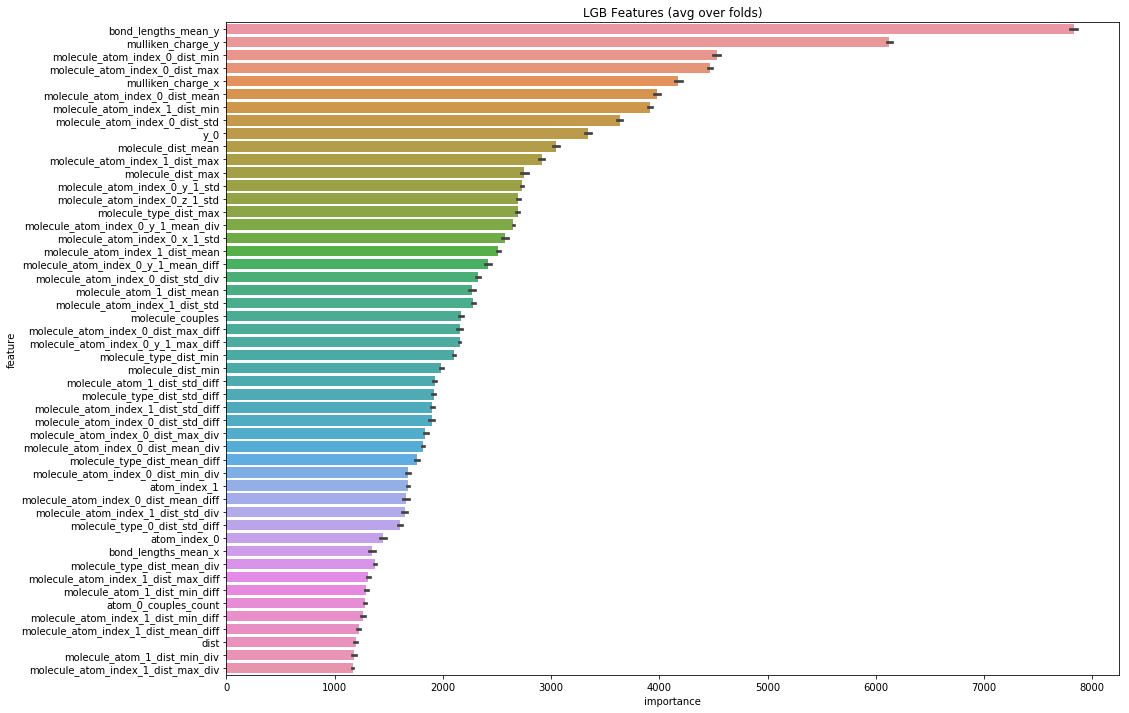

In [57]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb2 = train_model_regression(X=X, X_test=X_test, y=y_sd, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [58]:
oof_sd = result_dict_lgb2['oof']
test_oof_sd = result_dict_lgb2['prediction']

In [59]:
y = y_pso
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

In [60]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']

Training of type 0
Fold 1 started at Sat Jun 22 01:28:59 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0272225	valid_1's l1: 0.0331564
[1000]	training's l1: 0.0214977	valid_1's l1: 0.0304777
[1500]	training's l1: 0.017922	valid_1's l1: 0.0292166
[2000]	training's l1: 0.0153534	valid_1's l1: 0.0284697
[2500]	training's l1: 0.013329	valid_1's l1: 0.0279425
[3000]	training's l1: 0.0117277	valid_1's l1: 0.0275987
[3500]	training's l1: 0.0104007	valid_1's l1: 0.0273307
[4000]	training's l1: 0.00928059	valid_1's l1: 0.027115
[4500]	training's l1: 0.00833151	valid_1's l1: 0.0269467
[5000]	training's l1: 0.00752301	valid_1's l1: 0.026812
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00752301	valid_1's l1: 0.026812
Fold 2 started at Sat Jun 22 01:32:42 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0274254	valid_1's l1: 0.0332806
[1000]	training's l1: 0.02154	valid_1's l1: 0.030444

[3000]	training's l1: 0.00173956	valid_1's l1: 0.0276338
[3500]	training's l1: 0.00161611	valid_1's l1: 0.0276245
[4000]	training's l1: 0.00152268	valid_1's l1: 0.0276204
[4500]	training's l1: 0.00145081	valid_1's l1: 0.0276155
Early stopping, best iteration is:
[4576]	training's l1: 0.00144208	valid_1's l1: 0.0276145
Fold 2 started at Sat Jun 22 02:01:07 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.010712	valid_1's l1: 0.0285775
[1000]	training's l1: 0.00472783	valid_1's l1: 0.02784
[1500]	training's l1: 0.00285765	valid_1's l1: 0.027695
[2000]	training's l1: 0.00222914	valid_1's l1: 0.0276606
[2500]	training's l1: 0.00192616	valid_1's l1: 0.027642
[3000]	training's l1: 0.00174553	valid_1's l1: 0.027633
[3500]	training's l1: 0.00161825	valid_1's l1: 0.0276269
[4000]	training's l1: 0.00152767	valid_1's l1: 0.0276214
Early stopping, best iteration is:
[4141]	training's l1: 0.00150535	valid_1's l1: 0.027621
Fold 3 started at Sat Jun 22 02:01:

Fold 3 started at Sat Jun 22 02:19:39 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0283461	valid_1's l1: 0.032228
[1000]	training's l1: 0.0231926	valid_1's l1: 0.0292719
[1500]	training's l1: 0.0199785	valid_1's l1: 0.0277716
[2000]	training's l1: 0.0176367	valid_1's l1: 0.0268529
[2500]	training's l1: 0.015762	valid_1's l1: 0.0261953
[3000]	training's l1: 0.0142176	valid_1's l1: 0.0257076
[3500]	training's l1: 0.0129341	valid_1's l1: 0.0253444
[4000]	training's l1: 0.0118268	valid_1's l1: 0.0250545
[4500]	training's l1: 0.0108486	valid_1's l1: 0.0248234
[5000]	training's l1: 0.00999367	valid_1's l1: 0.0246262
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00999367	valid_1's l1: 0.0246262
Fold 4 started at Sat Jun 22 02:25:11 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0284754	valid_1's l1: 0.0321364
[1000]	training's l1: 0.0233228	valid_1's l1: 0.0292042
[1500]	trainin

[3500]	training's l1: 0.0124263	valid_1's l1: 0.0213093
[4000]	training's l1: 0.0115261	valid_1's l1: 0.0210458
[4500]	training's l1: 0.0107299	valid_1's l1: 0.0208325
[5000]	training's l1: 0.0100218	valid_1's l1: 0.0206634
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0100218	valid_1's l1: 0.0206634
Fold 4 started at Sat Jun 22 03:13:09 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0242976	valid_1's l1: 0.0268047
[1000]	training's l1: 0.0203839	valid_1's l1: 0.0244449
[1500]	training's l1: 0.0179456	valid_1's l1: 0.0232265
[2000]	training's l1: 0.0161263	valid_1's l1: 0.0224607
[2500]	training's l1: 0.0146715	valid_1's l1: 0.0219182
[3000]	training's l1: 0.0134518	valid_1's l1: 0.0215108
[3500]	training's l1: 0.0124096	valid_1's l1: 0.0211919
[4000]	training's l1: 0.0114965	valid_1's l1: 0.0209247
[4500]	training's l1: 0.0107079	valid_1's l1: 0.0207117
[5000]	training's l1: 0.00999416	valid_1's l1: 0.0205343
Did no

In [61]:
oof_pso = X_short['oof'].values
test_oof_pso = X_short_test['prediction'].values

Fold 1 started at Sat Jun 22 03:34:30 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0403288	valid_1's l1: 0.0416882
[1000]	training's l1: 0.0350874	valid_1's l1: 0.0373295
[1500]	training's l1: 0.0320744	valid_1's l1: 0.0350832
[2000]	training's l1: 0.0299126	valid_1's l1: 0.0335951
[2500]	training's l1: 0.0281835	valid_1's l1: 0.0324819
[3000]	training's l1: 0.0267919	valid_1's l1: 0.0316707
[3500]	training's l1: 0.0255825	valid_1's l1: 0.0310014
[4000]	training's l1: 0.0245199	valid_1's l1: 0.0304392
[4500]	training's l1: 0.0235859	valid_1's l1: 0.0299771
[5000]	training's l1: 0.0227355	valid_1's l1: 0.0295716
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0227355	valid_1's l1: 0.0295716
Fold 2 started at Sat Jun 22 03:53:49 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.040031	valid_1's l1: 0.0413644
[1000]	training's l1: 0.0350112	valid_1's l1: 0.0372484
[1500]	training

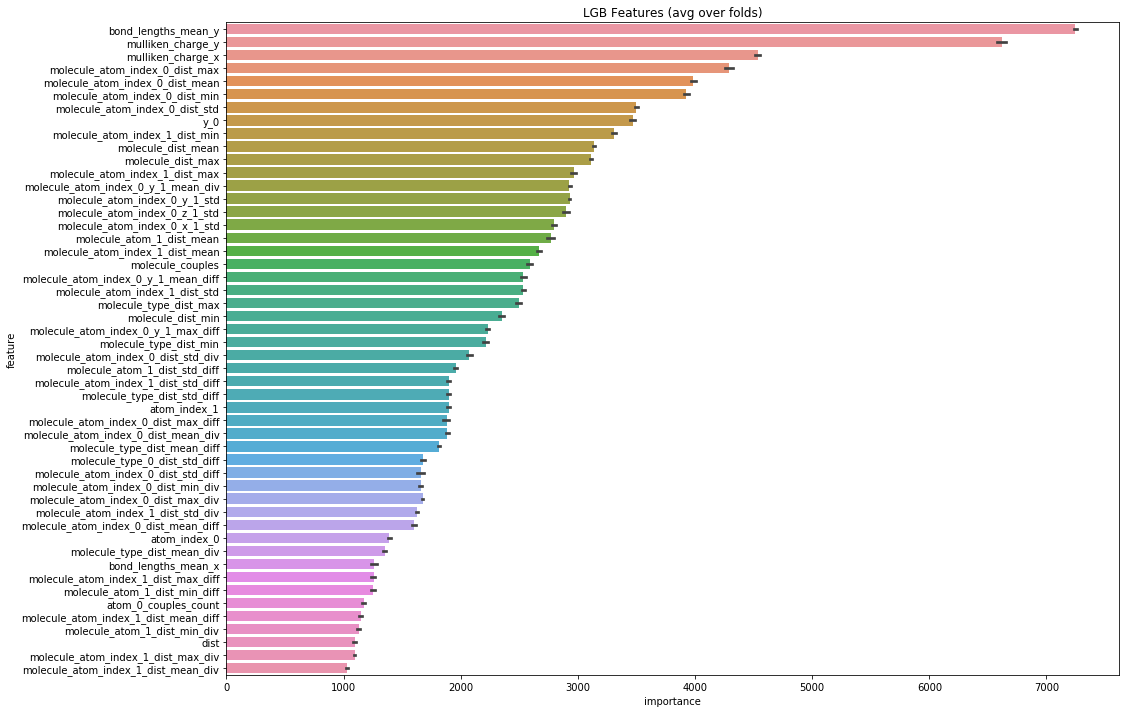

In [62]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb3 = train_model_regression(X=X, X_test=X_test, y=y_pso, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [63]:
oof_pso = result_dict_lgb3['oof']
test_oof_pso = result_dict_lgb3['prediction']

In [64]:
y = y_dso
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

In [65]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']

Training of type 0
Fold 1 started at Sat Jun 22 05:11:50 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.013705	valid_1's l1: 0.0163031
[1000]	training's l1: 0.010892	valid_1's l1: 0.0148896
[1500]	training's l1: 0.00911894	valid_1's l1: 0.0141793
[2000]	training's l1: 0.00785347	valid_1's l1: 0.0137601
[2500]	training's l1: 0.00687909	valid_1's l1: 0.0134597
[3000]	training's l1: 0.00609709	valid_1's l1: 0.0132491
[3500]	training's l1: 0.00545765	valid_1's l1: 0.0130835
[4000]	training's l1: 0.00492129	valid_1's l1: 0.0129559
[4500]	training's l1: 0.00446526	valid_1's l1: 0.0128513
[5000]	training's l1: 0.00407759	valid_1's l1: 0.0127681
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00407759	valid_1's l1: 0.0127681
Fold 2 started at Sat Jun 22 05:15:40 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0137389	valid_1's l1: 0.0162808
[1000]	training's l1: 0.0108924	valid_1's l1

[2500]	training's l1: 0.00113505	valid_1's l1: 0.00400515
[3000]	training's l1: 0.00110041	valid_1's l1: 0.00399983
Early stopping, best iteration is:
[2868]	training's l1: 0.00110041	valid_1's l1: 0.00399983
Fold 2 started at Sat Jun 22 05:44:15 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00187889	valid_1's l1: 0.00418208
[1000]	training's l1: 0.00143583	valid_1's l1: 0.00408027
[1500]	training's l1: 0.00127536	valid_1's l1: 0.00404843
[2000]	training's l1: 0.00118432	valid_1's l1: 0.0040302
[2500]	training's l1: 0.0011248	valid_1's l1: 0.00401901
[3000]	training's l1: 0.00108102	valid_1's l1: 0.00401104
[3500]	training's l1: 0.00104856	valid_1's l1: 0.00400584
Early stopping, best iteration is:
[3631]	training's l1: 0.00104029	valid_1's l1: 0.00400395
Fold 3 started at Sat Jun 22 05:44:33 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00186337	valid_1's l1: 0.00415752
[1000]	training's l1: 0.00

[1500]	training's l1: 0.0105601	valid_1's l1: 0.0144692
[2000]	training's l1: 0.0093388	valid_1's l1: 0.0139511
[2500]	training's l1: 0.00837135	valid_1's l1: 0.0135789
[3000]	training's l1: 0.00758629	valid_1's l1: 0.0133046
[3500]	training's l1: 0.00693042	valid_1's l1: 0.0131053
[4000]	training's l1: 0.00636914	valid_1's l1: 0.0129372
[4500]	training's l1: 0.00587886	valid_1's l1: 0.0128053
[5000]	training's l1: 0.00544431	valid_1's l1: 0.0126847
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00544431	valid_1's l1: 0.0126847
Fold 4 started at Sat Jun 22 06:07:16 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0149815	valid_1's l1: 0.0168583
[1000]	training's l1: 0.0122195	valid_1's l1: 0.015186
[1500]	training's l1: 0.0105485	valid_1's l1: 0.0143631
[2000]	training's l1: 0.00931659	valid_1's l1: 0.0138396
[2500]	training's l1: 0.00837494	valid_1's l1: 0.0134867
[3000]	training's l1: 0.00758331	valid_1's l1: 0.013200

[5000]	training's l1: 0.01194	valid_1's l1: 0.0254185
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.01194	valid_1's l1: 0.0254185
Fold 4 started at Sat Jun 22 06:56:14 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0300129	valid_1's l1: 0.033436
[1000]	training's l1: 0.0249286	valid_1's l1: 0.0303216
[1500]	training's l1: 0.0218298	valid_1's l1: 0.0287838
[2000]	training's l1: 0.0195251	valid_1's l1: 0.0278243
[2500]	training's l1: 0.0177218	valid_1's l1: 0.0271605
[3000]	training's l1: 0.0162146	valid_1's l1: 0.0266587
[3500]	training's l1: 0.0149357	valid_1's l1: 0.0262848
[4000]	training's l1: 0.0138172	valid_1's l1: 0.0259735
[4500]	training's l1: 0.0128376	valid_1's l1: 0.0257265
[5000]	training's l1: 0.011956	valid_1's l1: 0.0254977
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.011956	valid_1's l1: 0.0254977
Fold 5 started at Sat Jun 22 07:03:13 2019
Training until validation scores do

In [66]:
oof_dso = X_short['oof'].values
test_oof_dso = X_short_test['prediction'].values

Fold 1 started at Sat Jun 22 07:17:23 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.036394	valid_1's l1: 0.0379145
[1000]	training's l1: 0.0316622	valid_1's l1: 0.0340972
[1500]	training's l1: 0.0289627	valid_1's l1: 0.0321666
[2000]	training's l1: 0.0269388	valid_1's l1: 0.0308186
[2500]	training's l1: 0.0253526	valid_1's l1: 0.0298357
[3000]	training's l1: 0.0240572	valid_1's l1: 0.0291096
[3500]	training's l1: 0.0229388	valid_1's l1: 0.0285255
[4000]	training's l1: 0.0219452	valid_1's l1: 0.0280146
[4500]	training's l1: 0.0210481	valid_1's l1: 0.0275815
[5000]	training's l1: 0.0202487	valid_1's l1: 0.0272151
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0202487	valid_1's l1: 0.0272151
Fold 2 started at Sat Jun 22 07:37:04 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0363996	valid_1's l1: 0.037815
[1000]	training's l1: 0.0317311	valid_1's l1: 0.0340697
[1500]	training'

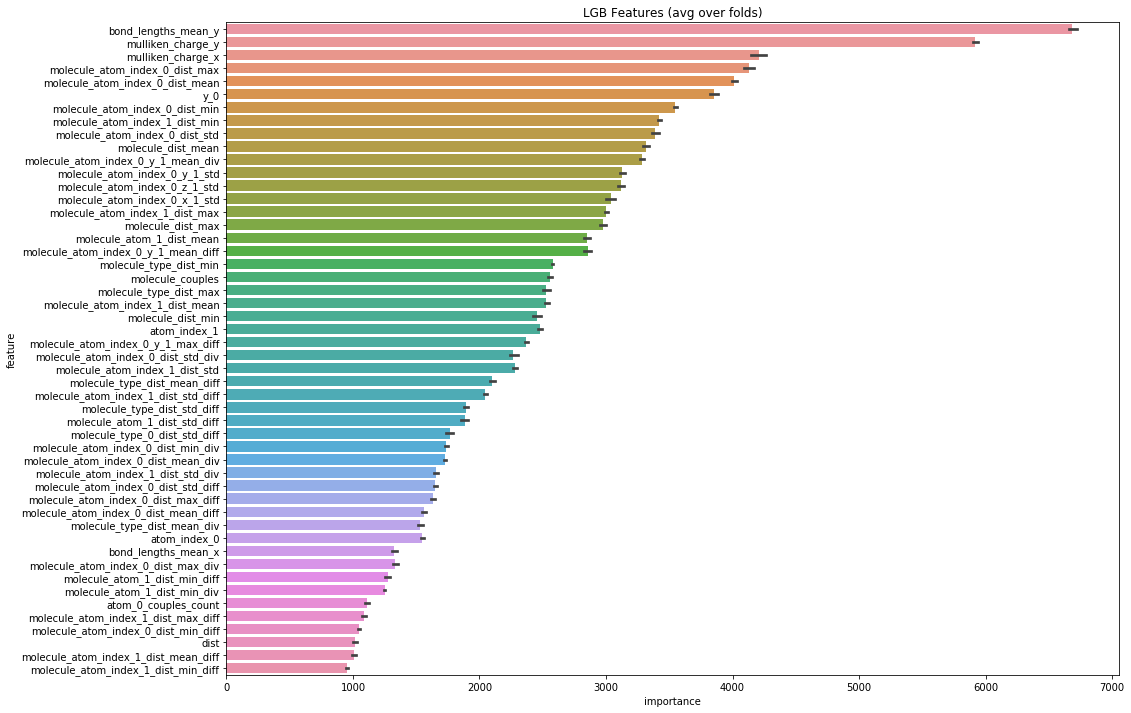

In [67]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb4 = train_model_regression(X=X, X_test=X_test, y=y_dso, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [68]:
oof_dso = result_dict_lgb4['oof']
test_oof_dso = result_dict_lgb4['prediction']

In [69]:
X['oof_fc'] = oof_fc
X_test['oof_fc'] = test_oof_fc

X['oof_sd'] = oof_sd
X_test['oof_sd'] = test_oof_sd

X['oof_pso'] = oof_pso
X_test['oof_pso'] = test_oof_pso

X['oof_dso'] = oof_dso
X_test['oof_dso'] = test_oof_dso

X['oof_scalar_cc'] = X['oof_fc'] + X['oof_sd'] + X['oof_pso'] + X['oof_dso']
X_test['oof_scalar_cc'] = X_test['oof_fc'] + X_test['oof_sd'] + X_test['oof_pso'] + X_test['oof_dso']

In [70]:
del result_dict_lgb1, result_dict_lgb2, result_dict_lgb3, result_dict_lgb4
gc.collect()

45195

Fold 1 started at Sat Jun 22 08:55:37 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0233852	valid_1's l1: 0.0243582
[1000]	training's l1: 0.0219175	valid_1's l1: 0.0236305
[1500]	training's l1: 0.0207896	valid_1's l1: 0.0231642
[2000]	training's l1: 0.0198408	valid_1's l1: 0.0228014
[2500]	training's l1: 0.019009	valid_1's l1: 0.0225001
[3000]	training's l1: 0.0182637	valid_1's l1: 0.0222365
[3500]	training's l1: 0.0175851	valid_1's l1: 0.0220093
[4000]	training's l1: 0.0169552	valid_1's l1: 0.0217966
[4500]	training's l1: 0.0163741	valid_1's l1: 0.02161
[5000]	training's l1: 0.0158295	valid_1's l1: 0.0214413
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0158295	valid_1's l1: 0.0214413
Fold 2 started at Sat Jun 22 09:16:20 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0234468	valid_1's l1: 0.0243476
[1000]	training's l1: 0.0219715	valid_1's l1: 0.0236131
[1500]	training's

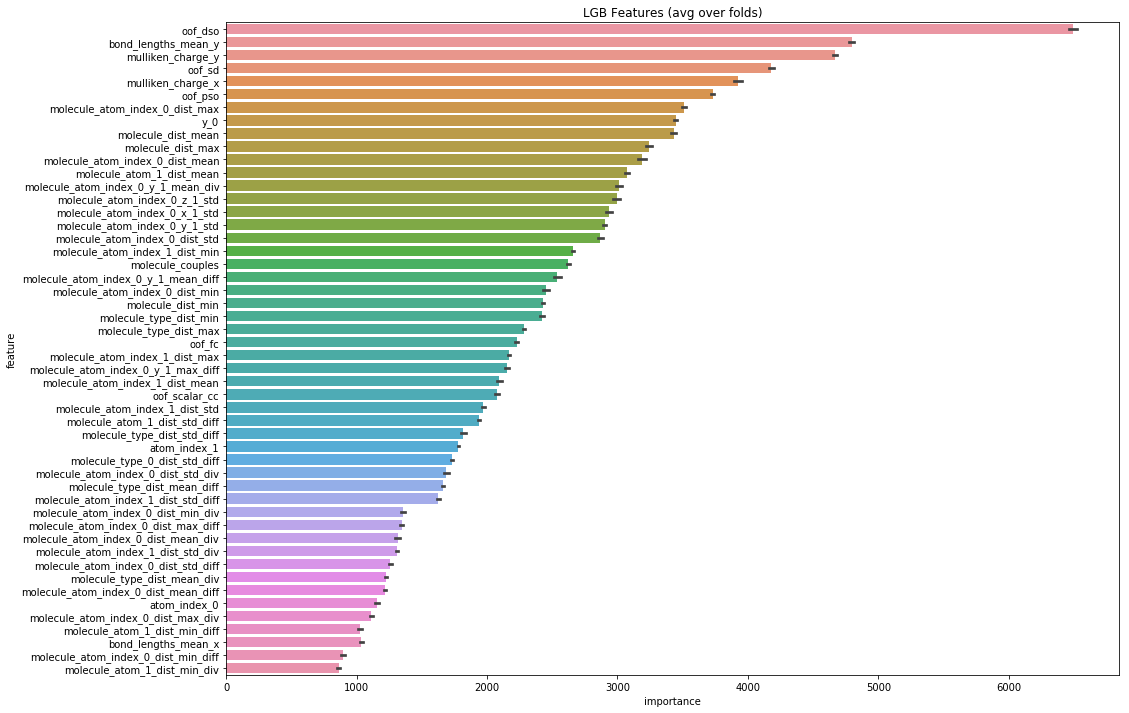

In [71]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [72]:
y = y1
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
    
sub['scalar_coupling_constant'] = X_short_test['prediction']
sub.to_csv('../submissions/sub8.csv', index=False)
sub.head()

Training of type 0
Fold 1 started at Sat Jun 22 10:39:26 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.955388	valid_1's l1: 1.12756
[1000]	training's l1: 0.795453	valid_1's l1: 1.09252
[1500]	training's l1: 0.676076	valid_1's l1: 1.07092
[2000]	training's l1: 0.581172	valid_1's l1: 1.05456
[2500]	training's l1: 0.504268	valid_1's l1: 1.0416
[3000]	training's l1: 0.440708	valid_1's l1: 1.03225
[3500]	training's l1: 0.387606	valid_1's l1: 1.02442
[4000]	training's l1: 0.342915	valid_1's l1: 1.01832
[4500]	training's l1: 0.304542	valid_1's l1: 1.01397
[5000]	training's l1: 0.271748	valid_1's l1: 1.01018
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.271748	valid_1's l1: 1.01018
Fold 2 started at Sat Jun 22 10:43:19 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.956027	valid_1's l1: 1.13487
[1000]	training's l1: 0.79547	valid_1's l1: 1.10104
[1500]	training's l1: 0.674893	valid

[1000]	training's l1: 0.091466	valid_1's l1: 0.464149
[1500]	training's l1: 0.0462482	valid_1's l1: 0.459598
[2000]	training's l1: 0.0236895	valid_1's l1: 0.458196
[2500]	training's l1: 0.011614	valid_1's l1: 0.457397
[3000]	training's l1: 0.0058681	valid_1's l1: 0.457125
[3500]	training's l1: 0.00351439	valid_1's l1: 0.456972
[4000]	training's l1: 0.00256318	valid_1's l1: 0.456938
[4500]	training's l1: 0.0021206	valid_1's l1: 0.456912
[5000]	training's l1: 0.00186481	valid_1's l1: 0.456903
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00186481	valid_1's l1: 0.456903
Fold 3 started at Sat Jun 22 11:13:09 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.200577	valid_1's l1: 0.482145
[1000]	training's l1: 0.0945348	valid_1's l1: 0.466027
[1500]	training's l1: 0.047341	valid_1's l1: 0.461788
[2000]	training's l1: 0.0236226	valid_1's l1: 0.460502
[2500]	training's l1: 0.0116273	valid_1's l1: 0.459939
[3000]	training's l1: 

[2000]	training's l1: 0.331021	valid_1's l1: 0.526704
[2500]	training's l1: 0.295165	valid_1's l1: 0.51858
[3000]	training's l1: 0.265045	valid_1's l1: 0.512152
[3500]	training's l1: 0.239583	valid_1's l1: 0.507364
[4000]	training's l1: 0.217855	valid_1's l1: 0.503617
[4500]	training's l1: 0.198528	valid_1's l1: 0.500389
[5000]	training's l1: 0.181476	valid_1's l1: 0.497617
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.181476	valid_1's l1: 0.497617
Fold 4 started at Sat Jun 22 11:38:08 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.513386	valid_1's l1: 0.58258
[1000]	training's l1: 0.434787	valid_1's l1: 0.552995
[1500]	training's l1: 0.37716	valid_1's l1: 0.534831
[2000]	training's l1: 0.332861	valid_1's l1: 0.523219
[2500]	training's l1: 0.2968	valid_1's l1: 0.514675
[3000]	training's l1: 0.267039	valid_1's l1: 0.508373
[3500]	training's l1: 0.241464	valid_1's l1: 0.503349
[4000]	training's l1: 0.219542	valid_1's l

[1000]	training's l1: 0.495219	valid_1's l1: 0.591555
[1500]	training's l1: 0.444785	valid_1's l1: 0.575888
[2000]	training's l1: 0.403178	valid_1's l1: 0.564205
[2500]	training's l1: 0.368058	valid_1's l1: 0.555069
[3000]	training's l1: 0.337879	valid_1's l1: 0.548193
[3500]	training's l1: 0.311618	valid_1's l1: 0.542433
[4000]	training's l1: 0.288176	valid_1's l1: 0.537492
[4500]	training's l1: 0.267321	valid_1's l1: 0.53351
[5000]	training's l1: 0.24872	valid_1's l1: 0.530032
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.24872	valid_1's l1: 0.530032
Fold 5 started at Sat Jun 22 12:37:50 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.559528	valid_1's l1: 0.614026
[1000]	training's l1: 0.494055	valid_1's l1: 0.589347
[1500]	training's l1: 0.443659	valid_1's l1: 0.573628
[2000]	training's l1: 0.401938	valid_1's l1: 0.562044
[2500]	training's l1: 0.366826	valid_1's l1: 0.553211
[3000]	training's l1: 0.336467	valid_1's

id  scalar_coupling_constant
0  4658147         8.219301273928441
1  4658148       188.478147575056965
2  4658149         6.494766975474673
3  4658150       188.002229454249090
4  4658151         7.173062877406764

In [73]:
%%time
!kaggle competitions submit -c champs-scalar-coupling -f ../submissions/sub8.csv -m ""

100%|██████████████████████████████████████| 64.0M/64.0M [00:21<00:00, 3.12MB/s]
Successfully submitted to Predicting Molecular PropertiesCPU times: user 584 ms, sys: 107 ms, total: 691 ms
Wall time: 24.2 s


In [75]:
from time import sleep
sleep(30)
!kaggle competitions submissions -c champs-scalar-coupling

fileName   date                 description  status    publicScore  privateScore  
---------  -------------------  -----------  --------  -----------  ------------  
sub8.csv   2019-06-22 07:22:48  None         complete  -0.903       None          
sub7.csv   2019-06-21 07:11:21  None         complete  -1.009       None          
sub6.csv   2019-06-11 10:26:26  None         complete  -0.939       None          
sub5.csv   2019-06-10 01:33:16  None         complete  -0.854       None          
sub4a.csv  2019-06-09 09:26:24  None         complete  -0.830       None          
sub4.csv   2019-06-09 06:05:24  None         complete  -0.603       None          
sub4.csv   2019-06-09 06:03:59  None         complete  -0.196       None          
sub3.csv   2019-06-09 00:57:08  None         complete  -0.376       None          
sub2b.csv  2019-06-08 17:53:30  None         complete  -0.690       None          
sub2a.csv  2019-06-08 14:09:52  None         complete  -0.642       None          
sub2

In [41]:
scalar_coupling_contributions.head()

molecule_name  atom_index_0  atom_index_1  type                  fc  \
0  dsgdb9nsd_000001             1             0  1JHC  83.022400000000005   
1  dsgdb9nsd_000001             1             2  2JHH -11.034700000000001   
2  dsgdb9nsd_000001             1             3  2JHH -11.032500000000001   
3  dsgdb9nsd_000001             1             4  2JHH -11.031900000000000   
4  dsgdb9nsd_000001             2             0  1JHC  83.022199999999998   

         sd      pso       dso  
0  0.254579  1.25862  0.272010  
1  0.352978  2.85839 -3.433600  
2  0.352944  2.85852 -3.433870  
3  0.352934  2.85855 -3.433930  
4  0.254585  1.25861  0.272013

In [3]:
0.254579	 +  1.25862 + 0.272010 + 83.022400000000005

84.807609